# Simulating fly-bys

This notebook will take you through a simulation of fly-bys of a star perturbing a planetary system.

### Imports

In [17]:
import rebound
import numpy as np
from scipy import spatial

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [73]:
import pickle

In [79]:
with open('sim_results_i0.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [80]:
results

[{'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1090.2273526322256],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1011.0826108972403],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1069.013744923368],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1069.5424735605038],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1318.2226662217256, 1338.2226662217256, 1938.2226662217256],
  'v_escapes': [1048.2226662217256,
   1058.2226662217256,
   1068.2226662217256,
   1078.2226662217256,
   1088.2226662217256,
   1098.22266622172

### Setup
Let's first create a simulation of our target planetary system. We'll use Sun and the outer planets of our solar system for now. Using NASA Horizons database to get the details of each object.

In [2]:
sim = rebound.Simulation()
particle_names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"]
# we use the NASA horizon database to look up the Sun and planets
sim.add(particle_names)

# let's give all the particles a unique hash (based on its name)
for i, particle in enumerate(sim.particles):
    particle.hash = particle_names[i]

sim.status()
    

Searching NASA Horizons for 'Sun'... 

KeyboardInterrupt: 

Let's save this simulation for future reference.

In [6]:
sim.save("solar_system_outer_planets.bin")

In [22]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
sim.integrate(10**6)
sim.status()

---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0000000000000000e+06
Current timestep:    	1.922840
---------------------------------
<rebound.Particle object, m=1.0 x=1.8571023142313239 y=4.505158999518282 z=0.05579575801210394 vx=0.00010973285292743885 vy=-0.0004353304883274691 vz=2.066748558783543e-06>
<rebound.Particle object, m=0.0009547919152112404 x=6.8147702502840595 y=6.73118953776824 z=-0.07725869827938392 vx=-0.17315013118184355 vy=0.38141414608509566 vz=-0.00032924316529987395>
<rebound.Particle object, m=0.0002858856727222417 x=9.322714404062348 y=-0.8332873658381746 z=-0.24580494591406266 vx=0.21018085977735299 vy=0.2627479070254194 vz=-0.006398792605082137>
<rebound.Particle object, m=4.36624373583127e-05 x=-15.44022591324002 y=13.728660728813322 z=0.2217606828122171 vx=-0.1069942017683012 vy=-0.1960591412410102 vz=0.008071389951229656>
<re

Let's define a function that simulates a single fly-by given a certain system and a particle that will be intruding the system.

In [70]:
def simulate_fly_by(sim, intruder, visualize=False):
    
    intruder.hash = "intruder"
    sim.add(intruder)
    
    intruder_distance = np.linalg.norm(sim.particles["intruder"].xyz)
    sim.exit_max_distance = intruder_distance*1.01
    
    while True:
        try:
            sim.integrate(sim.t+50)
            
            if visualize:
                fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
                display(fig)
                plt.close(fig)
                clear_output(wait=True)

        except rebound.Escape as error:
            if type(rebound.Escape()) == type(error):
                print("joe")
            # remove intruder
            sim.remove(hash="intruder")
            sim.move_to_com()
                    
            return sim


In [69]:
def evolve_system(sim, t, sim_results):
    sim.exit_max_distance = 500
    
    close_encounters = []
    ejections = []
    # set planet radii to their hill spheres
    for planet in sim.particles[1:]:
        planet.r = planet.rhill
        
    sim.collision = "direct"
    
    end_time = sim.t + t
    while sim.t < end_time:
        try:
            sim.integrate(sim.t + 10)
            if check_immediate_ejection(sim):
                sim_results["v_escapes"].append(sim.t)
            
            if check_orbit_crossing(sim.copy()):
                sim_results["orbit_crossing"].append(sim.t)

            if check_kozai(sim):
                sim_results["kozai"].append(sim.t)
            
        except (rebound.Collision, rebound.Escape) as error:
            #sim.status()
            if type(error) == type(rebound.Collision()):
                print(error, sim.t)
                collided = []
                for particle in sim.particles:
                    if particle.lastcollision == sim.t:
                        collided.append(particle.index)
                
                planet_1 = sim.particles[collided[0]]
                planet_2 = sim.particles[collided[1]]
                
                d = np.linalg.norm(np.array(planet_1.xyz) - np.array(planet_2.xyz))
                print(planet_1.index, planet_2.index, "close encounter. distance:", d)
            
                resolve_collision(sim)
                close_encounters.append(((planet_1.index, planet_2.index), d, sim.t))
                sim_results["close_encounters"].append(sim.t)
            
            else:
                print(error)
                out_of_bounds = []
                for i, particle in enumerate(sim.particles):
                    distance = np.linalg.norm(particle.xyz)
                    if distance > sim.exit_max_distance:
                        print("Removed", particle.index, str(particle.hash))
                        out_of_bounds.append(particle.hash)
                        ejections.append((particle.index, particle.xyz, sim.t))
                
                for hsh in out_of_bounds:
                        sim.remove(hash=hsh)
                        sim.move_to_com()
                        
                sim_results["escapes"].append(sim.t)
                        
    return (sim, close_encounters, ejections, sim_results)
    

In [5]:
def resolve_collision(sim):
    while True:
        try:
            sim.integrate(sim.t+0.1)
            return
        except:
            #  integrate one step without collision detection
            sim.collision = "none"
            sim.step()
            sim.collision = "direct"
            

In [8]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.0,x=30.6,y=-1000.,vy=2.)
sim = simulate_fly_by(sim, intruder)

evolve_system(sim, 10**7)

joe


In [29]:
sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_5788.bin")
for particle in sim.particles:
    print(particle.hash)
    
sim.status()

c_uint(3000342645)
c_uint(3586273463)
c_uint(4066125545)
c_uint(516400076)
c_uint(1470785325)
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	2.9558356028911448e+05
Current timestep:    	1.791724
---------------------------------
<rebound.Particle object, m=1.0 x=0.790392015242414 y=1.2800362480961802 z=0.010029648972591659 vx=-0.00042033941518836116 vy=0.000129634499445474 vz=1.1512510585973728e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.62321457248114 y=-3.5400958261243316 z=0.07831235094641473 vx=0.37710694334404987 vy=-0.19041810608900203 vz=-0.008487860358737817>
<rebound.Particle object, m=0.0002858856727222417 x=7.393583393592568 y=-6.584560782884102 z=-0.07737077919291399 vx=0.22619076558664736 vy=0.1970974490642162 vz=-0.012280195894553527>
<rebound.Particle object, m=4.36624373583127e-05 x=20.285578703970426 y=5.068961369614927 z=-

In [72]:
total_simulations = 200
max_evolve_time = 10**3
a_list = np.linspace(0, 100, total_simulations)

results = []


close_encounter_times = []
ejection_times = []

for sim_n in range(total_simulations):
    print(sim_n)
    
    sim_results = get_sim_results_dict()
    random_sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_{:04d}.bin".format(np.random.randint(0,10**4)))
    random_sim.t = 0
    sim_results["sim"] = random_sim
    
    intruder = rebound.Particle(m=1.0, x=a_list[sim_n], y=-1000., vy=2.)
    # save a copy of the intruder in sim_results
    sim_results["intruder"] = intruder.copy()
    
    sim = simulate_fly_by(random_sim, intruder, visualize=False)
    sim.status()
    sim_results["stable_after_fly_by"] = analyze_stability(sim)
    sim.status()
    result = evolve_system(sim, max_evolve_time, sim_results)
    sim, close_encounters, ejections, sim_results = result
    
    results.append(sim_results)
    
    if close_encounters:
        close_encounter_times.append(close_encounters[0][-1])
        
    if ejection_times:
        ejection_times.append(ejections[0][-1])
        
close_encounter_times.sort()   
fraction_encounters = np.arange(1, len(close_encounter_times) + 1) / total_simulations

ejection_times.sort()
fraction_ejections = np.arange(1, len(ejection_times) + 1) / total_simulations
    
    

0
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0902273526322256e+03
Current timestep:    	19.141191
---------------------------------
<rebound.Particle object, m=1.0 x=-0.843638388465763 y=0.1870182402801106 z=0.027484440593267934 vx=-0.0014324569749488703 vy=0.000306548108767124 vz=4.695892600903133e-05>
<rebound.Particle object, m=0.0009547919152112404 x=640.7059713965606 y=-84.9985752264565 z=-23.57328973662713 vx=1.0856950470685662 vy=-0.13827128978931186 vz=-0.04009259025689406>
<rebound.Particle object, m=0.0002858856727222417 x=592.8065737634183 y=-276.62792695130247 z=-12.37721764955074 vx=1.0125899232583504 vy=-0.4623703731464778 vz=-0.021868938323321693>
<rebound.Particle object, m=4.36624373583127e-05 x=539.1529836736364 y=-312.3446587716227 z=4.287921612079882 vx=0.9387890292875798 vy=-0.5219140968026758 vz=0.006791048449297685>
<reboun

A particle escaped (r>exit_max_distance).
Removed 1 c_uint(3586273463)
A particle escaped (r>exit_max_distance).
Removed 2 c_uint(516400076)
A particle escaped (r>exit_max_distance).
Removed 1 c_uint(4066125545)
5
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0170269926544715e+03
Current timestep:    	2.603910
---------------------------------
<rebound.Particle object, m=1.0 x=1.034111546665855 y=-0.30134297271960975 z=-0.08270143665335589 vx=0.002048170583635489 vy=-0.0005110403827601195 vz=-0.00016185043519802657>
<rebound.Particle object, m=0.0009547919152112404 x=-1079.0612510513379 y=320.47692275805264 z=86.27303987638714 vx=-2.08667847728881 vy=0.6126939449086889 vz=0.16670370893934686>
<rebound.Particle object, m=0.0002858856727222417 x=-7.018117756553636 y=5.733950946257465 z=0.10560077698435588 vx=-0.19164941722543355 vy=-0.2201022262834479

A particle escaped (r>exit_max_distance).
Removed 2 c_uint(516400076)
8
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0188770793934661e+03
Current timestep:    	18.877079
---------------------------------
<rebound.Particle object, m=1.0 x=-0.03343934527856618 y=-0.10598655832274417 z=0.004008502217825033 vx=-4.999827365559373e-05 vy=-0.0001831892749603048 vz=6.6838622070338e-06>
<rebound.Particle object, m=0.0009547919152112404 x=74.04761967450725 y=151.00745032861417 z=-4.273718657486252 vx=0.10708175735541353 vy=0.27048493490182807 vz=-0.006978210827476594>
<rebound.Particle object, m=0.0002858856727222417 x=-81.75850642797911 y=-113.85379002510638 z=-0.457587732241699 vx=-0.10620076316622667 vy=-0.20958792911260085 vz=-0.0014446476560898698>
<rebound.Particle object, m=4.36624373583127e-05 x=-131.71634466332242 y=-77.9490072934916 z=0.64192018486

A particle escaped (r>exit_max_distance).
Removed 2 c_uint(4066125545)
12
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0064973042606770e+03
Current timestep:    	2.233105
---------------------------------
<rebound.Particle object, m=1.0 x=0.0786312846493189 y=-0.053632521052444204 z=-0.008459679688680916 vx=-4.362600314583576e-06 vy=-0.00011870340716292963 vz=-1.2463678452650606e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1.0949017178428733 y=-15.162443736195915 z=0.09526030468273233 vx=0.18725731210767663 vy=-0.02008926201205595 vz=-0.0032896496043667693>
<rebound.Particle object, m=0.0002858856727222417 x=-286.08930327316915 y=242.74953505081635 z=29.038568083427606 vx=-0.5553132023002356 vy=0.491236093518462 vz=0.05327756142775408>
<rebound.Particle object, m=4.36624373583127e-05 x=-0.5495743179336472 y=9.890282255980305 z=-0.098190

16
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0167937193814118e+03
Current timestep:    	16.793719
---------------------------------
<rebound.Particle object, m=1.0 x=-0.15371089873849542 y=-0.24989272504545212 z=-0.006572470213549245 vx=-0.0002663749197386045 vy=-0.0004729923540127412 vz=-1.3142103871017667e-05>
<rebound.Particle object, m=0.0009547919152112404 x=91.50699922231888 y=206.9044472698706 z=0.5596270905450771 vx=0.14921497416582302 vy=0.38669298190049567 vz=0.0012070975283221064>
<rebound.Particle object, m=0.0002858856727222417 x=263.2252943563831 y=172.15352808842948 z=21.259582816294035 vx=0.47880217340809905 vy=0.3430266477394282 vz=0.04022833330055007>
<rebound.Particle object, m=4.36624373583127e-05 x=-152.65849366853928 y=-16.497897231841165 z=1.5924321986365806 vx=-0.2849377826630479 vy=-0.07777150865274893 vz=0.0033791514473

Two particles collided (d < r1+r2) 1132.4871566941008
1 2 close encounter. distance: 0.5064577665146127
Two particles collided (d < r1+r2) 1847.2812882400947
2 4 close encounter. distance: 0.7210229677836799
20
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050573737162114e+03
Current timestep:    	1.054062
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0028922911399078544 y=-0.0033337382246791947 z=7.112883031298173e-05 vx=0.0004818192916082459 vy=-0.00011262888117683119 vz=-1.1389674131985137e-05>
<rebound.Particle object, m=0.0009547919152112404 x=0.9398406325369635 y=5.2574816385320755 z=-0.0682213333530641 vx=-0.4666944590523846 vy=0.04451252198533931 vz=0.009664004569183962>
<rebound.Particle object, m=0.0002858856727222417 x=13.249892714859435 y=2.8489107960645264 z=-0.44293610848267295 vx=-0.12380218905884288 vy=0.234

24
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0051192057156807e+03
Current timestep:    	0.796990
---------------------------------
<rebound.Particle object, m=1.0 x=0.002567729315110512 y=0.0006574170449864525 z=-0.00011687733245198395 vx=0.00026816734018833555 vy=0.00021387603871816496 vz=-1.1053552760311499e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-3.7204048203169577 y=3.486162858248797 z=0.09460468899790103 vx=-0.34196795174404226 vy=-0.34225765171085204 vz=0.013207426987484495>
<rebound.Particle object, m=0.0002858856727222417 x=6.085337206377893 y=-0.5872107780786151 z=-0.10990315604902409 vx=0.1656962379230061 vy=0.38361232553218105 vz=-0.004634295443174137>
<rebound.Particle object, m=4.36624373583127e-05 x=8.145072597986754 y=-14.246058668077364 z=0.06494061473169337 vx=0.16384239503743983 vy=0.16864495775172744 vz=-0.004

28
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0052701858323317e+03
Current timestep:    	1.514112
---------------------------------
<rebound.Particle object, m=1.0 x=0.02661190694355753 y=-0.015347379168450137 z=-0.007890812905352063 vx=-4.720756200282672e-06 vy=-0.00043786994594870263 vz=-9.386200908496489e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.450134231108187 y=-2.3434488974260193 z=-0.14580449556337421 vx=0.1772773406055703 vy=0.410709166889937 vz=-0.008027189331707279>
<rebound.Particle object, m=0.0002858856727222417 x=1.9435291457037138 y=9.38475567330343 z=-0.15506770996115532 vx=-0.35333513219973234 vy=0.04306278016694279 vz=0.003900286413367598>
<rebound.Particle object, m=4.36624373583127e-05 x=-748.3730201803955 y=394.49193535761697 z=183.94535977959447 vx=-1.521168722255988 vy=0.7620614668634232 vz=0.36767861523049

32
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0057873731870260e+03
Current timestep:    	1.285571
---------------------------------
<rebound.Particle object, m=1.0 x=0.009012474654404912 y=0.0012759826773545702 z=-0.0002993668087962649 vx=8.453833610207184e-05 vy=0.0004587830845470195 vz=-7.326005014868804e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-5.5585785572821536 y=-0.004503285854827066 z=0.15694748976762748 vx=-0.021843890990900477 vy=-0.4101302950080211 vz=0.006384637505268316>
<rebound.Particle object, m=0.0002858856727222417 x=-5.996437238309195 y=6.803838814117097 z=0.2302824824572621 vx=-0.26452062583322755 vy=-0.20749535310722858 vz=0.004545429352436555>
<rebound.Particle object, m=4.36624373583127e-05 x=-4.843995510624232 y=-18.74398374808928 z=0.03604236923961308 vx=0.20146617061988387 vy=-0.05362713738356208 vz=-0.002

36
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0048782582560406e+03
Current timestep:    	0.822416
---------------------------------
<rebound.Particle object, m=1.0 x=-0.00012152876169935212 y=0.00041546870271574887 z=-3.916686170658866e-05 vx=0.00040516490882477885 vy=6.062981457006806e-05 vz=-1.6315557218389725e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.25005242669652 y=4.168959421291168 z=0.0073062532555353225 vx=-0.4882806297851254 vy=-0.11392909240126957 vz=0.01802376302082288>
<rebound.Particle object, m=0.0002858856727222417 x=6.178689538566058 y=-8.953212949644069 z=-0.053526867586895524 vx=0.22955257298196585 vy=0.18444186454977324 vz=-0.003143402613412634>
<rebound.Particle object, m=4.36624373583127e-05 x=-3.3714133683894048 y=17.785301908157322 z=0.018818793066126313 vx=-0.24268281244362833 vy=-0.05950728297451649 vz=0

A particle escaped (r>exit_max_distance).
Removed 3 c_uint(516400076)
40
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0052786897735785e+03
Current timestep:    	1.344604
---------------------------------
<rebound.Particle object, m=1.0 x=-0.004951975996750235 y=0.0069805702806425285 z=0.00010072135689826768 vx=-0.0003400517013883164 vy=-0.0003744426473059443 vz=1.1164200076873255e-05>
<rebound.Particle object, m=0.0009547919152112404 x=4.056984025376984 y=-2.9693240578255926 z=-0.07001415317155694 vx=0.2749794470719008 vy=0.35604810721046015 vz=-0.008192915356783789>
<rebound.Particle object, m=0.0002858856727222417 x=5.409025941476493 y=-9.199714673412267 z=-0.19116953859029504 vx=0.2589350547488854 vy=0.1412764040131992 vz=-0.01141425780620049>
<rebound.Particle object, m=4.36624373583127e-05 x=-22.0788018190516 y=15.856176470589617 z=0.041920855

A particle escaped (r>exit_max_distance).
Removed 3 c_uint(516400076)
44
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0054203714302686e+03
Current timestep:    	1.942332
---------------------------------
<rebound.Particle object, m=1.0 x=-0.009206670843326492 y=-0.0010962755985056694 z=0.00023586187530741484 vx=2.8784450641278214e-05 vy=-0.0004968404671554411 vz=3.8226639613467e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.501072612958204 y=-0.3200937514440778 z=-0.15327650882730734 vx=-0.000338981360554734 vy=0.4126220767692806 vz=-0.005404893618802079>
<rebound.Particle object, m=0.0002858856727222417 x=9.31332916816272 y=1.7879393174134723 z=-0.21171791961786834 vx=-0.054769861742827275 vy=0.31817615327213744 vz=0.0038946884684296903>
<rebound.Particle object, m=4.36624373583127e-05 x=24.4519847849304 y=-2.145213527556603 z=-0.18384

48
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0048837667100165e+03
Current timestep:    	1.783925
---------------------------------
<rebound.Particle object, m=1.0 x=-0.002228499652400018 y=0.0039073252213158716 z=-0.0003276014537985422 vx=-0.00036285124120386675 vy=-0.00023211912485701972 vz=1.3579654025620362e-05>
<rebound.Particle object, m=0.0009547919152112404 x=3.3924224713803817 y=-4.084193962524103 z=-0.048642508456326436 vx=0.30465501809104006 vy=0.28667245427584226 vz=-0.012694041042727327>
<rebound.Particle object, m=0.0002858856727222417 x=-5.1155421353879404 y=-9.748445918047796 z=0.033876854886900336 vx=0.2532338698651758 vy=-0.15094049248686917 vz=-0.00689123010492843>
<rebound.Particle object, m=4.36624373583127e-05 x=104.93039263965674 y=108.20827824571332 z=7.367803610019321 vx=0.14378813053178127 vy=0.19492901735902482 vz=0.013

52
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0051219216627024e+03
Current timestep:    	1.666710
---------------------------------
<rebound.Particle object, m=1.0 x=0.0035269486836035924 y=-0.0021337365911979767 z=-0.000138418574270139 vx=0.0002802092451795121 vy=0.0001794569911718108 vz=-1.013705728439807e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-2.412363898369019 y=5.029751023785253 z=0.06956176359790578 vx=-0.3803005098095862 vy=-0.17038335631894697 vz=0.011809587545343178>
<rebound.Particle object, m=0.0002858856727222417 x=-1.2781368820622134 y=-9.960648621269753 z=0.22890847921835628 vx=0.2931976628054625 vy=-0.028981049673527146 vz=-0.00514724150377533>
<rebound.Particle object, m=4.36624373583127e-05 x=-6.043321730968595 y=-17.67438693633829 z=0.1355855780818652 vx=0.22341256963764394 vy=-0.07970933250958437 vz=-0.0017765

A particle escaped (r>exit_max_distance).
Removed 4 c_uint(1470785325)
56
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0061020284458505e+03
Current timestep:    	1.518268
---------------------------------
<rebound.Particle object, m=1.0 x=0.005640835373061037 y=-0.0005194368124931681 z=-0.0001938462186996232 vx=0.000114905226732194 vy=0.0003838013170717338 vz=-6.616539548372583e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-4.9288530463588955 y=2.1048200681443325 z=0.1528973545046763 vx=-0.1805246817090061 vy=-0.38858994926544854 vz=0.007442924755597111>
<rebound.Particle object, m=0.0002858856727222417 x=-0.9179553934036448 y=-11.618583413485185 z=0.19068951181809227 vx=0.27443553544145244 vy=-0.020197768671164663 vz=-0.00347282295183625>
<rebound.Particle object, m=4.36624373583127e-05 x=-6.5456122576201174 y=18.46824869957389 z=-0.152

60
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0055740015913871e+03
Current timestep:    	1.350193
---------------------------------
<rebound.Particle object, m=1.0 x=0.002935153350037467 y=-0.002973884771787949 z=-4.226755713953928e-05 vx=7.738032394219441e-07 vy=0.00035035236220097587 vz=1.363386204046884e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-5.027032046001938 y=-1.4680205222556364 z=0.15496343883023966 vx=0.10083667838328632 vy=-0.41919719188252585 vz=-0.0025320784088454064>
<rebound.Particle object, m=0.0002858856727222417 x=4.242976895401341 y=9.455134048288748 z=-0.28228709000297514 vx=-0.2774778755403969 vy=0.15285348426710735 vz=0.002383402774864616>
<rebound.Particle object, m=4.36624373583127e-05 x=18.43438608766929 y=12.43636782488805 z=-0.21122172784485632 vx=-0.1379420457655564 vy=0.15970467407882077 vz=0.000515696

64
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0048250059391787e+03
Current timestep:    	1.464211
---------------------------------
<rebound.Particle object, m=1.0 x=0.007050786235204498 y=0.005531614919738415 z=-0.0002695579709324405 vx=-0.0002955106223479012 vy=0.0003851325104000606 vz=4.594731107394442e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-4.024089154667825 y=-3.750148403939019 z=0.15502328415240008 vx=0.2727191734191798 vy=-0.30376220658325964 vz=-0.002910538249658867>
<rebound.Particle object, m=0.0002858856727222417 x=-8.894432039093676 y=-3.3975069312985355 z=0.2626150979645416 vx=0.11645813313790454 vy=-0.2994324429181187 vz=-0.005917738094535361>
<rebound.Particle object, m=4.36624373583127e-05 x=-8.947982302478454 y=13.32807300819313 z=0.14713834091851397 vx=-0.16602312263858868 vy=-0.1815575476999491 vz=0.0019162182

68
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0058821548266797e+03
Current timestep:    	1.368076
---------------------------------
<rebound.Particle object, m=1.0 x=0.004114607756861233 y=0.002234940662789564 z=-0.0001620408048874089 vx=-0.00017818287997792975 vy=0.00030718690699913133 vz=-9.266413991825243e-07>
<rebound.Particle object, m=0.0009547919152112404 x=-4.173950227809142 y=-3.4550649470225143 z=0.13178504851258196 vx=0.25292469992035116 vy=-0.33283978834511657 vz=-0.0020576279328326013>
<rebound.Particle object, m=0.0002858856727222417 x=2.191339758902771 y=11.109351743111427 z=-0.03756647869714658 vx=-0.27916798447615476 vy=0.06557238016856068 vz=0.01092029062799987>
<rebound.Particle object, m=4.36624373583127e-05 x=-12.733616316770311 y=-13.455401562177798 z=0.2439562998294715 vx=0.1639720256635166 vy=-0.15912535238301287 vz=0.0003

72
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0046676715884856e+03
Current timestep:    	1.251501
---------------------------------
<rebound.Particle object, m=1.0 x=-0.004705339366687156 y=-0.007546319634715637 z=0.0002231846574066703 vx=0.00044399558958107405 vy=-0.0003048631850980806 vz=-8.453233361394541e-06>
<rebound.Particle object, m=0.0009547919152112404 x=2.77206190685507 y=4.051591964714751 z=-0.09767839100638256 vx=-0.39209652961403935 vy=0.24760269594544326 vz=0.006195571329004373>
<rebound.Particle object, m=0.0002858856727222417 x=8.531583402770751 y=5.195422777179749 z=-0.35635779708922116 vx=-0.17803521418410595 vy=0.2561465852899426 vz=0.007389562867523058>
<rebound.Particle object, m=4.36624373583127e-05 x=-4.683026660753477 y=18.00246360226579 z=-0.11693394567629435 vx=-0.20024568677355115 vy=-0.08283756400296076 vz=0.002711316

76
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0055592172357982e+03
Current timestep:    	1.831229
---------------------------------
<rebound.Particle object, m=1.0 x=-0.003105405570389408 y=0.002929629310080062 z=-1.6426272063673614e-05 vx=-0.00019741409678264085 vy=-0.00027151339723858683 vz=9.806948595536358e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.275366571285673 y=-3.237763099035745 z=-0.07202531802456974 vx=0.250111671439693 vy=0.34089735978338975 vz=-0.01101029722371747>
<rebound.Particle object, m=0.0002858856727222417 x=-7.797798001615014 y=7.70242201940072 z=0.30183895986586295 vx=-0.19995151269659764 vy=-0.21142739533862784 vz=0.003680822660040355>
<rebound.Particle object, m=4.36624373583127e-05 x=0.18584064944695555 y=-18.215484933207524 z=0.22542888289567484 vx=0.23000718498221 vy=0.005071919934952446 vz=-0.00211907

80
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0054931462316202e+03
Current timestep:    	1.756280
---------------------------------
<rebound.Particle object, m=1.0 x=0.001079013771303039 y=0.004678776275389318 z=-0.00011866754882394227 vx=-0.0003305277428727327 vy=4.772876658315554e-05 vz=5.285228561724383e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-0.25928939456775346 y=-5.392973405933177 z=0.059511773391546785 vx=0.4217351597604283 vy=-0.019168247045111473 vz=-0.009086463622768501>
<rebound.Particle object, m=0.0002858856727222417 x=-2.2726943088820963 y=8.831081224134902 z=0.1074966627356821 vx=-0.32339828811804705 vy=-0.09269244114864503 vz=0.013188355643418912>
<rebound.Particle object, m=4.36624373583127e-05 x=-6.870534851373652 y=-17.463789790242494 z=0.23939236935502173 vx=0.22183070205989347 vy=-0.08430907831485293 vz=-0.00

84
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0061104736982179e+03
Current timestep:    	1.914605
---------------------------------
<rebound.Particle object, m=1.0 x=0.0018026457289401776 y=0.006602123697074469 z=-5.006518840432791e-05 vx=-0.000403599610778467 vy=0.00022496413049596508 vz=7.64292198930887e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-3.588011194192225 y=-4.185468562716463 z=0.13339688311867404 vx=0.3200574499412928 vy=-0.2623312768926459 vz=-0.0041754215012182565>
<rebound.Particle object, m=0.0002858856727222417 x=1.8812068034165446 y=-8.931483046908312 z=-0.1231551618184614 vx=0.3310767403229224 vy=0.06063285322429345 vz=-0.012414554448753714>
<rebound.Particle object, m=4.36624373583127e-05 x=0.2405381381649292 y=-18.956479616495468 z=-0.015429299565659957 vx=0.22498730341358883 vy=-0.0042176820020717876 vz=-0.0025

88
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0055095009283796e+03
Current timestep:    	1.452466
---------------------------------
<rebound.Particle object, m=1.0 x=-0.009312158237023027 y=0.0005120866523481427 z=0.00024343744099018707 vx=2.8071490418970363e-05 vy=-0.0005251900018080832 vz=4.895760571590592e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.030327759336323 y=0.3988698749310594 z=-0.13885765048826734 vx=-0.056271613567748124 vy=0.4470335341812926 vz=-0.004715772107933775>
<rebound.Particle object, m=0.0002858856727222417 x=9.185625672906752 y=-3.211308339215549 z=-0.2971164154770269 vx=0.10780732625950605 vy=0.3008346527817903 vz=-0.0008502850534569316>
<rebound.Particle object, m=4.36624373583127e-05 x=9.999956000521792 y=17.611157712149673 z=-0.11304791092873859 vx=-0.20349995049135616 vy=0.09451004528247839 vz=0.002108

92
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0047330441027572e+03
Current timestep:    	1.467932
---------------------------------
<rebound.Particle object, m=1.0 x=0.006048113038664482 y=0.000430972351673109 z=-0.0002292318395378328 vx=-8.36550922037882e-05 vy=0.0004252553599366395 vz=-7.948590266870064e-07>
<rebound.Particle object, m=0.0009547919152112404 x=-4.958659811696596 y=-2.2235868528457137 z=0.1817305451023277 vx=0.15794321504534672 vy=-0.38825167655917125 vz=0.00011527905423207325>
<rebound.Particle object, m=0.0002858856727222417 x=-6.488599770187528 y=7.091445290490366 z=0.1651165947119238 vx=-0.24303122270145897 vy=-0.206023816686155 vz=0.003392798139881171>
<rebound.Particle object, m=4.36624373583127e-05 x=8.432109062239723 y=18.40288367967912 z=-0.1152164756228328 vx=-0.21082829072166231 vy=0.07659625820641461 vz=0.002067350313

96
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050189051577304e+03
Current timestep:    	1.556829
---------------------------------
<rebound.Particle object, m=1.0 x=0.006552508175158067 y=0.004433964302383103 z=-0.00024928646945988724 vx=-0.00024846393264544783 vy=0.0004145010628901275 vz=2.665175593018279e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-4.245249129176936 y=-3.3729538445244547 z=0.11143496624312892 vx=0.2547491686446971 vy=-0.33455579879214975 vz=-0.003305756231641246>
<rebound.Particle object, m=0.0002858856727222417 x=-9.025435800100162 y=-0.9137623576040179 z=0.39724632278739885 vx=0.021402690147830587 vy=-0.3372162679112739 vz=0.0022095507247120666>
<rebound.Particle object, m=4.36624373583127e-05 x=4.656744964760263 y=19.15850852456909 z=-0.20517978305142442 vx=-0.21220625397792606 vy=0.047266400776197454 vz=0.0012

100
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050347008950132e+03
Current timestep:    	1.310362
---------------------------------
<rebound.Particle object, m=1.0 x=-4.174446852189817e-05 y=-0.00439375176488542 z=-3.836219533902979e-05 vx=0.00040833805738977116 vy=-0.00012700404036752378 vz=-1.059747886434434e-05>
<rebound.Particle object, m=0.0009547919152112404 x=2.493088325043132 y=4.316144007141688 z=-0.06962593730025751 vx=-0.3984748257338868 vy=0.22380885801194342 vz=0.008493102527288979>
<rebound.Particle object, m=0.0002858856727222417 x=-9.106002354180658 y=2.795008863903262 z=0.29983205404926777 vx=-0.10448436315190363 vy=-0.31226403650336226 vz=0.009537528237816261>
<rebound.Particle object, m=4.36624373583127e-05 x=7.915419550263977 y=18.027976346297816 z=-0.18302407529774856 vx=-0.1951774623423744 vy=0.07753014236832659 vz=0.001188

104
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0056275075893585e+03
Current timestep:    	2.046242
---------------------------------
<rebound.Particle object, m=1.0 x=0.0011743338475582732 y=0.004915777152267542 z=-0.00013166876642615403 vx=-0.0003666890293890744 vy=-5.080533700728483e-05 vz=1.301966572475607e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1.603245806422171 y=-5.119708435181513 z=0.02565336549864529 vx=0.39954645964523383 vy=0.14246398780818023 vz=-0.013191091510561425>
<rebound.Particle object, m=0.0002858856727222417 x=-9.89849257799152 y=2.0182317853097476 z=0.27057516843952756 vx=-0.05358485767010762 vy=-0.3039319475170506 vz=-0.0010191777554586646>
<rebound.Particle object, m=4.36624373583127e-05 x=7.515087984677599 y=18.516242960118525 z=-0.09708214764812528 vx=-0.21355916491514215 vy=0.07045398737890982 vz=0.00219

108
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0053503210167079e+03
Current timestep:    	1.384941
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0031816309400216625 y=0.000537268529927637 z=6.514167638500953e-05 vx=2.7687112232818722e-06 vy=-0.00034511349880914587 vz=6.4777044892499886e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.029932307253027 y=-0.1659398138775371 z=-0.12455808218905033 vx=-0.005980543001992598 vy=0.4522898537765461 vz=-0.006004248065213249>
<rebound.Particle object, m=0.0002858856727222417 x=-9.446243873425543 y=0.43788901226710986 z=0.31673974320051246 vx=-0.014693388962068298 vy=-0.32327477165975543 vz=-0.0018124402334434467>
<rebound.Particle object, m=4.36624373583127e-05 x=-7.87221480538231 y=-17.881695141310082 z=0.07940654765561346 vx=0.21586142137068234 vy=-0.0897953429214967 vz=

112
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0051835559149350e+03
Current timestep:    	1.634363
---------------------------------
<rebound.Particle object, m=1.0 x=0.00422681650726453 y=0.00015385782034671447 z=-0.00015716948542669057 vx=-0.00011345831101099157 vy=0.00031314199894840524 vz=-2.8784921863726054e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-4.692854448828348 y=-2.902906871736443 z=0.1495747890740613 vx=0.21246534071021977 vy=-0.35326181270638934 vz=-0.00048327869237230686>
<rebound.Particle object, m=0.0002858856727222417 x=3.2745979170634687 y=8.98496648735377 z=-0.06721221994106832 vx=-0.3054198778249224 vy=0.10647088661204188 vz=0.01169129985913081>
<rebound.Particle object, m=4.36624373583127e-05 x=5.3730286021836235 y=18.991125034459547 z=-0.05028979959576816 vx=-0.22297969003907242 vy=0.04660116225040542 vz=0.00

116
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050442424874589e+03
Current timestep:    	1.238322
---------------------------------
<rebound.Particle object, m=1.0 x=0.005952391430732007 y=-0.0015713510056769575 z=-0.0001769178317476785 vx=0.00032486418104512096 vy=0.000337217140812469 vz=-9.791455163055893e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-3.263037823901059 y=4.037490339692251 z=0.03121917522688658 vx=-0.35688652084530287 vy=-0.2544589157172231 vz=0.010086152040449216>
<rebound.Particle object, m=0.0002858856727222417 x=-9.383037241781679 y=0.17346605893067935 z=0.39717433618788306 vx=-0.01264876593493758 vy=-0.3282253953560976 vz=0.0016360939808099297>
<rebound.Particle object, m=4.36624373583127e-05 x=2.4034111562342346 y=-19.423259157445028 z=-0.08003411815354228 vx=0.23085610588448277 vy=0.02722045916367138 vz=-0.002

120
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0055773001154332e+03
Current timestep:    	1.364737
---------------------------------
<rebound.Particle object, m=1.0 x=0.0025154019323760934 y=2.972477109886712e-05 z=-9.652646359595632e-05 vx=0.0001884395878681 vy=0.00028473232177469424 vz=-3.684693350548553e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-4.503424355033326 y=2.498875518245623 z=0.12082923614278142 vx=-0.22682650127322132 vy=-0.3794360276867482 vz=0.006614752648620738>
<rebound.Particle object, m=0.0002858856727222417 x=9.637013064685508 y=-2.3316750566301314 z=-0.21276058919783414 vx=0.04652231806060845 vy=0.3098717484685541 vz=-0.008403547876878692>
<rebound.Particle object, m=4.36624373583127e-05 x=-16.047361455624756 y=-8.871464696918048 z=0.18502368482504478 vx=0.11185308818555878 vy=-0.20678220025651578 vz=0.00010256

124
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0046932681807306e+03
Current timestep:    	1.587706
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0016426795527291205 y=0.00016688502707012942 z=2.8459528970022074e-06 vx=-8.621313204926206e-05 vy=-0.00030150531529203503 vz=4.095310085088243e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.010870718199813 y=-1.5019628467112707 z=-0.09474539343781782 vx=0.1046208026314411 vy=0.42278314574543213 vz=-0.005482848763667675>
<rebound.Particle object, m=0.0002858856727222417 x=-9.326157178067863 y=0.7644360658957576 z=0.39444433168698556 vx=-0.026748520294763704 vy=-0.3315588309375177 vz=0.002990593850743957>
<rebound.Particle object, m=4.36624373583127e-05 x=-17.021695449622843 y=-7.18474498463338 z=0.19764833933860843 vx=0.09081401771365316 vy=-0.21545862868523327 vz=0.0

128
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0061310957315496e+03
Current timestep:    	1.865091
---------------------------------
<rebound.Particle object, m=1.0 x=0.0031163104020430765 y=0.004900585513608391 z=-3.807518176454877e-05 vx=-0.00033439399642506105 vy=0.00020846341808745405 vz=5.7469039626752095e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-3.878274811354977 y=-3.885770454206122 z=0.11777265268129612 vx=0.2984583270098306 vy=-0.2871916045910712 vz=-0.0037513211189748263>
<rebound.Particle object, m=0.0002858856727222417 x=8.44741567583269 y=-4.703252671800218 z=-0.34236688332588605 vx=0.15690207149395113 vy=0.27471426160844836 vz=-0.007919230853191>
<rebound.Particle object, m=4.36624373583127e-05 x=-8.781125575997374 y=-16.456423464261167 z=0.07031096509506701 vx=0.198874777338578 vy=-0.11606007639209265 vz=-0.00261230

132
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0051242242042337e+03
Current timestep:    	1.684775
---------------------------------
<rebound.Particle object, m=1.0 x=-6.007068636826318e-05 y=0.003764972522108275 z=-2.1174302306371448e-05 vx=-0.00029230264089726704 vy=0.00020709359748499403 vz=1.0145164785692853e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-3.850798563249729 y=-3.6838789949046116 z=0.11191941268551694 vx=0.29142899351274015 vy=-0.31282228952908614 vz=-0.00782065288982105>
<rebound.Particle object, m=0.0002858856727222417 x=9.239217254140453 y=-3.1779238484461603 z=-0.16855794558629775 vx=0.07865508773358001 vy=0.3057785086304811 vz=-0.009081934795019389>
<rebound.Particle object, m=4.36624373583127e-05 x=-9.606626534171571 y=16.701521147883675 z=-0.0010713961281151952 vx=-0.19521464402634997 vy=-0.12317819983298085 vz

136
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0048916052973714e+03
Current timestep:    	1.734472
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0029638263495517236 y=-0.0007664242590127573 z=0.00012306906779910656 vx=-6.726852954402375e-05 vy=-0.00033119605586941973 vz=6.084720264950553e-08>
<rebound.Particle object, m=0.0009547919152112404 x=4.798402391478568 y=-2.022409496683095 z=-0.11401473615254258 vx=0.15701241453686682 vy=0.4083420844823319 vz=-0.004568697719658133>
<rebound.Particle object, m=0.0002858856727222417 x=-5.097533825629606 y=7.012590165153798 z=0.031675960429164436 vx=-0.29131699049945686 vy=-0.19941666772288957 vz=0.014415218365753272>
<rebound.Particle object, m=4.36624373583127e-05 x=-2.922793316871511 y=-18.76907538384209 z=0.14089707408145447 vx=0.23407842457895411 vy=-0.03516591487828167 vz=-0.0

140
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0057350754826251e+03
Current timestep:    	1.583639
---------------------------------
<rebound.Particle object, m=1.0 x=-0.004371942637613202 y=0.002633287701054421 z=0.0001308842759697301 vx=-0.0002880779215286462 vy=-0.0004051862957929761 vz=1.1409985442557898e-05>
<rebound.Particle object, m=0.0009547919152112404 x=3.9830551961143605 y=-3.247465333602994 z=-0.0516892584578114 vx=0.26036460027826347 vy=0.35835096957014373 vz=-0.010423545372469816>
<rebound.Particle object, m=0.0002858856727222417 x=7.846784684058889 y=-5.372714031286218 z=-0.3231485114168509 vx=0.1889873027377177 vy=0.26113398811209537 vz=-0.006247926610726698>
<rebound.Particle object, m=4.36624373583127e-05 x=-10.029162889490658 y=15.865883936537772 z=0.1247424203491957 vx=-0.19510309561123995 vy=-0.13339096044875404 vz=0.0020456

144
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0061210619376191e+03
Current timestep:    	1.588761
---------------------------------
<rebound.Particle object, m=1.0 x=-0.009449673894918575 y=-0.0006826357103849601 z=0.00024386025787473224 vx=3.5579333707624894e-05 vy=-0.0005114063737693896 vz=3.2217367752447376e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.193890538240328 y=-0.33135009982209296 z=-0.11212434162777705 vx=0.0034934441792565905 vy=0.43700710060015213 vz=-0.004753236298967953>
<rebound.Particle object, m=0.0002858856727222417 x=9.268911137872333 y=3.7448765677201776 z=-0.36525486817359276 vx=-0.12268574264342641 vy=0.28474778409244283 vz=0.005466630990098671>
<rebound.Particle object, m=4.36624373583127e-05 x=10.036445956457001 y=16.967989636546903 z=-0.26101218356352507 vx=-0.18710859612683886 vy=0.10938496459153726 vz=

148
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050622753728710e+03
Current timestep:    	1.649056
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0017189024279877785 y=0.005478045148740673 z=-7.822798242969158e-05 vx=-0.0003684114997496886 vy=8.259170304644963e-05 vz=9.64686691164923e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-2.4901445706338423 y=-4.84672621310936 z=0.13632581005962766 vx=0.3687724897168871 vy=-0.19566975253332125 vz=-0.009794147938154977>
<rebound.Particle object, m=0.0002858856727222417 x=8.954478264841676 y=-1.9259726687301413 z=-0.13508609497506704 vx=0.06896454780145601 vy=0.33017737273890757 vz=-0.0003913491543852108>
<rebound.Particle object, m=4.36624373583127e-05 x=6.950904561760093 y=18.394030116025398 z=-0.11397692427038152 vx=-0.21147813530921286 vy=0.07013680611845652 vz=0.00207

152
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0049404523735481e+03
Current timestep:    	1.231494
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0004737086765498333 y=-0.0018051526705088472 z=6.79791617249053e-05 vx=0.00037998036213036414 vy=6.527301896655194e-05 vz=-8.382162756086476e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-1.7704572019543754 y=4.646301573293575 z=0.00393044232615318 vx=-0.4318218771569462 vy=-0.1520919494368135 vz=0.010263553103570038>
<rebound.Particle object, m=0.0002858856727222417 x=9.946187867853862 y=-1.6585948981268903 z=-0.41668811155543994 vx=0.04653515163365143 vy=0.3016035905915771 vz=-0.0041219630870232655>
<rebound.Particle object, m=4.36624373583127e-05 x=-6.179986389585698 y=-17.427993000322715 z=0.20763086460174413 vx=0.2200919281516881 vy=-0.0804094951510508 vz=-0.00094

156
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0053287935515309e+03
Current timestep:    	1.700624
---------------------------------
<rebound.Particle object, m=1.0 x=0.003468909114591412 y=0.00423607951486471 z=-0.00010997419807067324 vx=-0.0003495684196317059 vy=0.00013684624043044924 vz=1.1832688840813193e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-0.7745153681989896 y=-5.339924894061456 z=0.06199203268467087 vx=0.417052415998364 vy=-0.0624306315801838 vz=-0.013668808246784044>
<rebound.Particle object, m=0.0002858856727222417 x=-8.571023865507087 y=4.6412434032127745 z=0.05702154900133479 vx=-0.17000786293309075 vy=-0.26569591703041034 vz=0.004535560828315519>
<rebound.Particle object, m=4.36624373583127e-05 x=6.456048074263845 y=18.74412818878022 z=-0.12380243533599776 vx=-0.21221124196107838 vy=0.06331388500789642 vz=0.0019413

160
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0052427498482156e+03
Current timestep:    	1.856808
---------------------------------
<rebound.Particle object, m=1.0 x=0.0013497421332893111 y=0.0074153088813808665 z=-0.0001633714019809284 vx=-0.00040708574652727723 vy=-2.8545837705048895e-05 vz=1.1690081180573213e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1.3368258241517115 y=-5.176883507425202 z=0.035484167702261926 vx=0.40606959731944287 vy=0.12714861818890552 vz=-0.011349007517047252>
<rebound.Particle object, m=0.0002858856727222417 x=-9.541258746248118 y=0.061910519750126736 z=0.34620168399495793 vx=0.0017402746877651937 vy=-0.3241649723546546 vz=-0.0018098694031146946>
<rebound.Particle object, m=4.36624373583127e-05 x=-1.3379501702698287 y=-19.15663855993165 z=0.008428887533908868 vx=0.22921376784914302 vy=-0.02372295781135389

164
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0052445410188571e+03
Current timestep:    	1.330003
---------------------------------
<rebound.Particle object, m=1.0 x=0.004226898608021834 y=-0.00805713140095038 z=-2.748109142269861e-05 vx=0.00045489229007416795 vy=0.00028210671862090065 vz=-1.5738639867545536e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-2.6115285785865057 y=4.270430826748547 z=0.061301555433550314 vx=-0.3918481093580633 vy=-0.22912328963470038 vz=0.014634843513229098>
<rebound.Particle object, m=0.0002858856727222417 x=-7.602816116862027 y=5.935259553082987 z=0.028625346948868854 vx=-0.2159522055733698 vy=-0.2349603010240872 vz=0.005103130251956521>
<rebound.Particle object, m=4.36624373583127e-05 x=6.135805136719731 y=18.869653470105586 z=-0.12244126910669886 vx=-0.21315337750542565 vy=0.05996302191342888 vz=0.00193

168
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0056620057347737e+03
Current timestep:    	1.763590
---------------------------------
<rebound.Particle object, m=1.0 x=-0.009125454741695016 y=0.0019072782197198102 z=0.00020981881762417894 vx=-0.00016143362339018918 vy=-0.0004562050668289789 vz=9.388356356893832e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.778529515917091 y=-2.64317314507744 z=-0.13948933224079968 vx=0.19744298921133321 vy=0.3660019904188875 vz=-0.009537075970018247>
<rebound.Particle object, m=0.0002858856727222417 x=8.852780376648434 y=2.756669107146785 z=-0.11558928612959787 vx=-0.11041975652724058 vy=0.31521365353745356 vz=-2.0851301143822316e-05>
<rebound.Particle object, m=4.36624373583127e-05 x=13.838063209193516 y=-12.699267153011162 z=0.049146332038036346 vx=0.1663683612912967 vy=0.1672587173802095 vz=-0.0041

172
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0057881038166007e+03
Current timestep:    	1.167039
---------------------------------
<rebound.Particle object, m=1.0 x=0.005767780125953692 y=-0.003850746121259463 z=-8.914416075383493e-05 vx=0.00032631297750891977 vy=0.00037244515483053517 vz=-1.08974512777559e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-3.2043626988479987 y=3.739343897792595 z=0.03157297450208171 vx=-0.358859418875809 vy=-0.290038678931184 vz=0.012526292315061815>
<rebound.Particle object, m=0.0002858856727222417 x=-9.29049207131991 y=-1.7152563036679158 z=0.30637346091145495 vx=0.0646421828468209 vy=-0.3213134506716431 vz=-0.004435636682787425>
<rebound.Particle object, m=4.36624373583127e-05 x=-13.310004927552015 y=-12.828194426688617 z=0.26222139808520145 vx=0.16289552063580942 vy=-0.1681467698080722 vz=0.000678551

176
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0056284656134367e+03
Current timestep:    	2.096682
---------------------------------
<rebound.Particle object, m=1.0 x=0.00020500437971815444 y=0.0038744553529669323 z=2.1642391976891585e-05 vx=-0.00037198392772148405 vy=7.351128090017643e-05 vz=7.682307453141422e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-2.3687599998519975 y=-4.868709163804078 z=0.08605886291087746 vx=0.384429045483928 vy=-0.1700218586869554 vz=-0.006900819433459821>
<rebound.Particle object, m=0.0002858856727222417 x=9.647629860871454 y=-1.8602519445547112 z=-0.39625906545382156 vx=0.05077645252140676 vy=0.3098096564243183 vz=-0.004988380419250122>
<rebound.Particle object, m=4.36624373583127e-05 x=16.792401987450752 y=10.470790573182502 z=-0.17558551098685504 vx=-0.11848237222177864 vy=0.18230276359275863 vz=0.0019

180
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0055907997537266e+03
Current timestep:    	1.491365
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0020568373800715634 y=-0.002513974575218958 z=4.078016197624212e-06 vx=0.0002485043252768906 vy=-0.0002891702406776787 vz=-1.329924426117921e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.538348291181174 y=2.276328458450835 z=-0.13327239113320358 vx=-0.22196682112246618 vy=0.3897745319678919 vz=0.0005447179869386356>
<rebound.Particle object, m=0.0002858856727222417 x=-8.470834924775307 y=3.9149559873946598 z=0.337170937588593 vx=-0.13356248200468185 vy=-0.30207782471736705 vz=0.0035387421427913054>
<rebound.Particle object, m=4.36624373583127e-05 x=11.812240439935906 y=15.903154055134106 z=-0.27604304573668054 vx=-0.17402209420063613 vy=0.1307604996384544 vz=-8.94504

184
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0059056253286743e+03
Current timestep:    	1.384274
---------------------------------
<rebound.Particle object, m=1.0 x=0.007883500307305447 y=0.00019835777056353976 z=-0.0002527059882232257 vx=8.616013828410818e-05 vy=0.00047873549593935327 vz=-5.065654239242913e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-5.257016306064086 y=1.2569455217177887 z=0.10080681630237363 vx=-0.11344430634042772 vy=-0.40505567113931007 vz=0.005769395051348601>
<rebound.Particle object, m=0.0002858856727222417 x=-9.127409438324433 y=-2.585001815839027 z=0.40829622216089645 vx=0.08020119318466333 vy=-0.315874108607025 vz=-0.001343501866595142>
<rebound.Particle object, m=4.36624373583127e-05 x=1.6549076177326496 y=19.25092539316376 z=0.023358217279972504 vx=-0.22891020025869085 vy=0.00698441285964262 vz=0.00271

188
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0055299624664841e+03
Current timestep:    	1.722760
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0029294371352577286 y=0.007244464617080365 z=-2.936579627391047e-05 vx=-0.0004467947506843605 vy=-0.0001016430430161281 vz=1.4661457889088176e-05>
<rebound.Particle object, m=0.0009547919152112404 x=0.20838493809754777 y=-5.4232243917458245 z=0.04257108643434005 vx=0.41835497616361744 vy=0.01843786358522674 vz=-0.014237344184810001>
<rebound.Particle object, m=0.0002858856727222417 x=7.682718716692277 y=-4.9274197191690945 z=-0.07553420147398165 vx=0.17120436408221323 vy=0.2912790605797834 vz=-0.0031359653736080448>
<rebound.Particle object, m=4.36624373583127e-05 x=-5.955928508678341 y=18.3321939020004 z=0.013481469083003138 vx=-0.21498580351396146 vy=-0.08144180548354435 vz=0.0

192
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0056271758984805e+03
Current timestep:    	1.424316
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0033875148772173347 y=-0.006259797313237562 z=0.00013234882037985087 vx=0.00044444010135750826 vy=-0.00018546416856696365 vz=-1.1152724710235998e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1.1693470148319447 y=4.906651844796286 z=-0.04495103798732642 vx=-0.43893309000990777 vy=0.10315439707345199 vz=0.013195365519472282>
<rebound.Particle object, m=0.0002858856727222417 x=9.183739540387418 y=0.930867073260919 z=-0.20285949660235564 vx=-0.05970663180302063 vy=0.3296069340983082 vz=-0.005806310999359272>
<rebound.Particle object, m=4.36624373583127e-05 x=-18.29747189844784 y=-1.8024986308617919 z=0.1755737686574582 vx=0.02490528846005679 vy=-0.23575900487050466 vz=0.00

196
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0057747364440097e+03
Current timestep:    	1.495420
---------------------------------
<rebound.Particle object, m=1.0 x=-0.006261169578484882 y=-0.0007116880093089584 z=8.750507262375584e-05 vx=0.00028381697905599523 vy=-0.00032387698238172015 vz=-7.55568045151339e-06>
<rebound.Particle object, m=0.0009547919152112404 x=2.974796046305493 y=4.101786144170814 z=-0.10122769829108551 vx=-0.36764388094003697 vy=0.25813189304576317 vz=0.010832908526415457>
<rebound.Particle object, m=0.0002858856727222417 x=6.5039230569539805 y=-7.2972443193445695 z=0.028306939658813444 vx=0.2202154469548871 vy=0.22548796203427302 vz=-0.008768883095438525>
<rebound.Particle object, m=4.36624373583127e-05 x=18.227857297379565 y=7.979573870893189 z=-0.20358352997809023 vx=-0.08341030164296871 vy=0.20063247745182733 vz=-4.358

In [63]:
def get_sim_results_dict():
    dic = dict()
    dic["sim"] = 0
    dic["intruder"] = 0
    dic["close_encounters"] = []
    dic["escapes"] = []
    dic["v_escapes"] = []
    dic["kozai"] = []
    dic["orbit_crossing"] = []
    dic["stable_after_fly_by"] = 0
    
    return dic

a = get_sim_results_dict()
a["escapes"].append(1)
a["escapes"]

[1]

AttributeError: 'list' object has no attribute 'savefig'

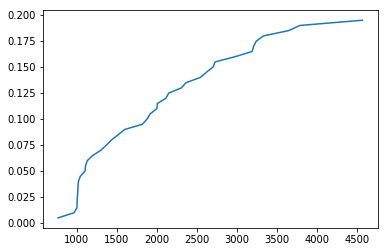

In [79]:
first_ejections_times = []
for result in results:
    if result[2]:
        first_ejections_times.append(result[2][0][-1])

first_ejections_times.sort()
fraction_ejections = np.arange(1, len(first_ejections_times) + 1) / len(results)

plt.plot(first_ejections_times, fraction_ejections).savefig("fraction_first_ejection_vs_time_eject_10_5")    

In [ ]:
[dict(sim: sim,
      intruder: intruder
    close_enocunters: [t, t, t,],
    escapes: [],
      v_escapes: [],
     kozai: [],
     orbit_crossing: []
    ), ..., ..., ..., ...,]

In [75]:
total_ejections = 0
for result in results:
    if result[2]:
        total_ejections += 1


In [6]:
39/200

0.195

In [12]:
def hill_radius(planet, star):
    return planet.a * (1 - planet.e) * np.cbrt(planet.m / (3. * star.m))

In [17]:
def calc_mutual_hill_radii_matrix(sim):
    host_star = sim.particles[0]
    
    hill_radii = np.zeros((len(sim.particles[1:]), len(sim.particles[1:])))

    # find largest mutual hill radius in sim
    for i, planet_1 in enumerate(sim.particles[1:]):
        for j, planet_2 in enumerate(sim.particles[i+2:]):
            j = j + i + 1
            print(i,j)
            mutual_hill_radius = calc_mutual_hill_radius(planet_1, planet_2, host_star.m)
            hill_radii[i][j] = mutual_hill_radius
            hill_radii[j][i] = mutual_hill_radius
    
    return hill_radii

# TEST
calc_mutual_hill_radii_matrix(sim)
    

0 1
0 2
0 3
1 2
1 3
2 3


array([[0.        , 0.54933768, 0.84528148, 1.22556907],
       [0.54933768, 0.        , 0.6881079 , 0.95618489],
       [0.84528148, 0.6881079 , 0.        , 0.77981562],
       [1.22556907, 0.95618489, 0.77981562, 0.        ]])

In [3]:
def calc_mutual_hill_radius(p1, p2, m_host):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    mutual_hill_radius = (p1.a + p2.a) / 2. * np.cbrt((p1.m + p2.m) / (3. * m_host))
    return mutual_hill_radius
    

In [13]:
def calc_escape_velocity(sim, particle):
    #sim.move_to_hel()
    
    r = np.linalg.norm(particle.xyz)
    G = sim.G
    m = sim.particles[0].m
    
    return np.sqrt(2 * G * m / r)

In [37]:
def strong_regime(resolution=100, n_trials=50):
    print("Starting strong regime simulation with resolution {}, {} trials each...".format(resolution, n_trials))
    xs = np.linspace(1, 50, resolution)
    f_eject = np.ones(resolution)
    
    for i, x in enumerate(xs):
        print("Running r_min =", x)
        eject_count = 0.
        
        # run n_trials trials detecting ejection directly after fly-by
        for j in range(n_trials):
            # get a fresh simulation
            sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
            sim = randomize_sim(sim)
            
            intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
            
            sim = simulate_fly_by(sim, intruder)
            
            sim.move_to_hel()
            for particle in sim.particles:
                v = np.linalg.norm(particle.vxyz)
                v_esc = calc_escape_velocity(sim, particle)
                if v > v_esc:
                    eject_count += 1
                    break
        print("Detected", eject_count, "ejections out of", n_trials, "trials.")
        f_eject[i] = eject_count / n_trials
        print(f_eject[i])

    
    return (xs, f_eject)            

Let's define a function to predict the stabillity of a system directly after a fly-by.

Instabillity can be defined in a number of ways. The simplest being direct ejection from the system.

This function will try to analyze the stability of a system based on direct observations of it's orbits properties.

In [9]:
def analyze_stability(sim):
    """Check stabillity of an orbit return True if (possibly) stable, False if unstable"""
    
    if check_immediate_ejection(sim) == True:
        return False
    
    elif check_orbit_crossing(sim) == True:
        return False
    
    elif check_kozai(sim) == True:
        return False
    
    elif check_AMD(sim) == True:
        return False
    
    else:
        return True
    

In [8]:
def check_immediate_ejection(sim):
    # move to Sun frame
    sim.move_to_hel()
    
    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            sim.move_to_com()
            return True
        
    sim.move_to_com()
    
    return False
    


In [19]:
sim = rebound.Simulation()
sim.add(m=1.)


In [27]:
def check_kozai(sim):
    # compare all particles
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True
    
    return False
            

Starting strong regime simulation with resolution 30, 100 trials each...
Running r_min = 1.0


/home/simon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Detected 100.0 ejections out of 100 trials.
1.0
Running r_min = 2.689655172413793
Detected 100.0 ejections out of 100 trials.
1.0
Running r_min = 4.379310344827586
Detected 94.0 ejections out of 100 trials.
0.94
Running r_min = 6.068965517241379
Detected 82.0 ejections out of 100 trials.
0.82
Running r_min = 7.758620689655173
Detected 83.0 ejections out of 100 trials.
0.83
Running r_min = 9.448275862068966
Detected 69.0 ejections out of 100 trials.
0.69
Running r_min = 11.137931034482758
Detected 67.0 ejections out of 100 trials.
0.67
Running r_min = 12.827586206896552
Detected 49.0 ejections out of 100 trials.
0.49
Running r_min = 14.517241379310345
Detected 50.0 ejections out of 100 trials.
0.5
Running r_min = 16.20689655172414
Detected 44.0 ejections out of 100 trials.
0.44
Running r_min = 17.896551724137932
Detected 32.0 ejections out of 100 trials.
0.32
Running r_min = 19.586206896551726
Detected 35.0 ejections out of 100 trials.
0.35
Running r_min = 21.275862068965516
Detected 32

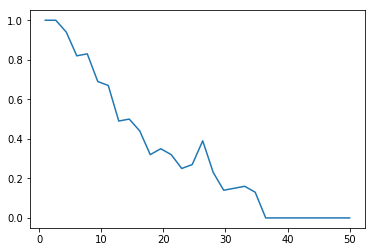

In [30]:
xs, f_eject = strong_regime(resolution=30, n_trials=100)

plt.plot(xs, f_eject)

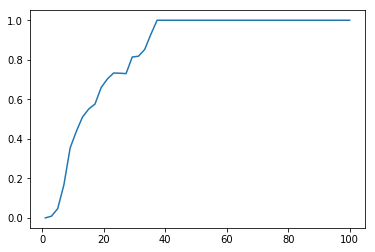

In [50]:
plt.plot(xs, 1-f_eject)

In [32]:
a = np.ones(10)
a[2] = 5
a


array([1., 1., 5., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
def randomize_sim(sim):
    sim.integrate(np.random.random()*10**3)
    return sim
    

In [60]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
simulate_fly_by(sim, intruder, visualize=True)

In [13]:
sim.particles[4].inc

0.030897078503559147

In [65]:
def mutual_rhill(p1, p2):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    rhill_m = (p1.a + p2.a) / 2. * ((p1.m + p2.m) / 3.)**(1/3.)
    return rhill_m


def orbit_list(simulation, period, particle, step_size):
    """
    Creates list of points on an orbit.
    """

    locations = []
    total_time = 0
#     Temporary simulation, adding sun and the particle we want the orbit from
    temp_sim = rebound.Simulation()
    temp_sim.add(simulation.particles[0])
    temp_sim.add(particle)
    
#     Integrating over exactly one orbit
    while total_time < period:
        temp_sim.integrate(temp_sim.t+step_size)
        total_time += step_size
        locations.append(temp_sim.particles[1].xyz)
    return np.array(locations)


def check_orbit_crossing(simulation):
    """
    Checks in a simulation whether any orbits cross.
    """

#     Creating and saving lists with points on orbits
    locationslist = []
    for i, particle in enumerate(simulation.particles[1:]):
        orbit = particle.calculate_orbit()
        step_size = orbit.P * orbit.rhill / (2 * np.pi * orbit.a)
        locationslist.append(orbit_list(simulation,
                                        abs(orbit.P), particle.copy(), abs(step_size)))

#     creating distance matrix
    for i, loc1 in enumerate(locationslist):
        for j, loc2 in enumerate(locationslist[i+1:]):
            dist_mat = spatial.distance_matrix(loc1, loc2)
            if dist_mat[np.where(dist_mat < mutual_rhill(simulation.particles[i+1],
                    simulation.particles[j+i+2]))].size > 0:
                # print(f"Planet {i+1} and {i+j+2} (counting from star) will collide!")
                return True

    return False


def check_immediate_ejection(sim):
    """
    Checks whether there is a planet in the simulation with v > v_escape.
    """

    # move to Sun frame
    sim.move_to_hel()

    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles[1:]:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            sim.move_to_com()
            return True

    sim.move_to_com()
    return False


def check_kozai(sim):
    """
    Checks whether the kozai mechanism is happening in a simulation.
    """

    # compare all particles except the star
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i+2:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True

    return False



def randomize_sim(sim):
    """
    Integrates simulation for any number of time between 0 and 999.
    """
    sim.integrate(random.randint(0, 999))
    return sim


def analyze_stability(sim):

    if check_immediate_ejection(sim) == True:
        print("v > v_esc")
        return False

    elif check_orbit_crossing(sim) == True:
        print("orbit crossing")
        return False

    elif check_kozai(sim) == True:
        print("Kozai mechanism activated")
        return False

    else:
        return True